In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPUs Available:  1


In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [4]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
%matplotlib inline

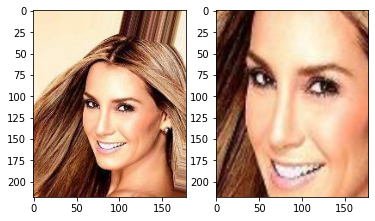

In [5]:
face_cascade = cv.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
def detect_faces(img):
    # reducing the data size to lower our number of features
    grey_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(grey_image)
    return detected_faces
# Crop the image from the picture
def crop_face(img):
    faces = detect_faces(img)
    if len(faces) == 0:
        return img
    else:
        column, row, width, height = faces[0]
        cropped = img[row:row+height, column:column+width]
        return cv.resize(cropped, img.shape[0:2][::-1])
image = plt.imread('celeb-dataset/img_align_celeba/img_align_celeba/000001.jpg')
    
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(crop_face(image));

In [6]:
# Each identity has to have its own folder
# Preprocessing block
import pandas as pd
from shutil import copyfile
from tqdm.notebook import tqdm
import os

train_size = 900
test_size = 100

file = 'identity-celeba/identity_CelebA.txt'
identities = pd.read_csv(file, delimiter=' ', names=['file', 'identity'])

source_dir = 'celeb-dataset/img_align_celeba/img_align_celeba/%s'
target_dir_train = 'working/train/%d/'
target_dir_test = '/working/test/%d/'

def get_dest_dir(identity):
    if identity <= train_size:
        return target_dir_train
    elif identity <= train_size + test_size:
        return target_dir_test
    else:
        return None

for _, file, identity in tqdm(list(identities.itertuples())):
    dest_dir = get_dest_dir(identity)
    if dest_dir is not None:
        dest_dir = dest_dir % identity
        os.makedirs(dest_dir, exist_ok=True)
        copyfile(source_dir % file, dest_dir + file)


  0%|          | 0/202599 [00:00<?, ?it/s]

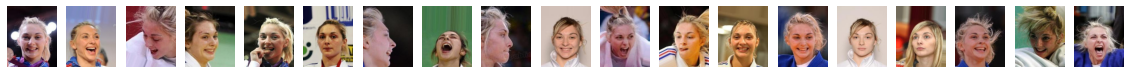

  0%|          | 0/900 [00:00<?, ?it/s]

Loaded 900 classes


  0%|          | 0/100 [00:00<?, ?it/s]

Loaded 100 classes


In [7]:
def show_class(class_name, cl='train'):
    # Check to make sure that all files in each directory are of the same person (sanity check)
    files = glob.glob('working/%s/%s/*' % (cl, class_name))
    # matplotlib plotting
    fig, ax = plt.subplots(1, len(files), figsize=(20,10))
    for index, file in enumerate(files):
        ax[index].imshow(cv.cvtColor(cv.imread(file), cv.COLOR_BGR2RGB))
        ax[index].axis('off')
    plt.show()
    
show_class('925', 'test')

# Create the image preprocessor 
from keras.preprocessing.image import ImageDataGenerator
import random

def preprocess_image(img):
    # image must be an int for cropping and float for Keras
    return 

train_directory = 'working/train/'
test_directory = 'working/test/'
batch_size = 128

class DirectoryFlow:
    def __init__(self, directory, batch_size, in_memory=True):
        self.directory = directory
        self.batch_size = batch_size
        self.in_memory = in_memory
        if in_memory:
            self.file_structure = self.load_images(directory)
        else: 
            self.file_structure = {int(f): [directory + '%s/%s' % (f, file_name) for file_name in os.listdir(directory + f)] for f in os.listdir(directory)}
        self.classes = list(self.file_structure.keys())
        print('Loaded %d classes' % len(self.classes))
        
    def load_images(self, directory):
        structure = {}
        for f in tqdm(os.listdir(directory)):
            structure[int(f)] = [self.read_image(directory + '%s/%s' % (f, file_name)) for file_name in os.listdir(directory + f)]
        return structure
    
    def read_image(self, file):
        img = cv.imread(file)
        img = cv.resize(img, (64, 64))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = crop_face(img.astype('uint8'))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = img.astype('float32')/255
        img = img.reshape(*img.shape, 1)
        return img
    
    def next(self, class_name=None):
        if class_name is None:
            class_name = random.choice(self.classes)
        item = random.choice(self.file_structure[class_name])
        
        if self.in_memory:
            return item, class_name
        else:
            return self.read_image(item), class_name
    
    def next_batch(self):
        images = []
        labels = np.zeros((self.batch_size))
        for i in range(self.batch_size):
            image, class_name = self.next()
            images.append(image)
            labels[i] = class_name
        return np.array(images), labels
# Pre processing over
datagen_train = DirectoryFlow(train_directory, batch_size)
datagen_test = DirectoryFlow(test_directory, batch_size)

# datagen_test = DirectoryFlow(test_directory)

In [7]:
# Model Creationco
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Dense, Add, Conv2D, MaxPooling2D, Lambda, BatchNormalization, GaussianNoise
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K

input_shape = (64, 64, 1)

def make_facial_feature_cnn():
    network_input = Input(shape=input_shape)
    face = Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same', name='conv1')(network_input)
    face = Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same', name='conv2')(face)
    face = Conv2D(64, kernel_size=(8,8), strides=(3,3), activation='relu', padding='same', name='conv3')(face)

    face = Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same', name='conv4')(face)
    face = Conv2D(64, kernel_size=(9,9), strides=(4,4), activation='relu', padding='same', name='conv5')(face)
    face = Conv2D(32, kernel_size=(5,5), strides=(2,2), activation='relu', padding='same', name='conv6')(face)
    
    face = Flatten()(face)
    face= Dropout(0.15)(face)
    face = Dense(32, activation='tanh')(face)
    face = BatchNormalization()(face)

    return Model(network_input, face)

# variable to hold model map
facial_feature_cnn = make_facial_feature_cnn()

input_face_left = Input(shape=input_shape, name='model_face_left')
input_face_right = Input(shape=input_shape, name='model_face_right')

model_face_left = facial_feature_cnn(input_face_left)
model_face_right = facial_feature_cnn(input_face_right)

merged_model = Lambda(lambda tensors: abs(tensors[0] - tensors[1]), name='absolute_difference')([model_face_left, model_face_right])
merged_model = GaussianNoise(0.5)(merged_model)
merged_model = Dense(64, activation='relu', name='d1')(merged_model)
merged_model = Dropout(0.1, name='drop1')(merged_model)
merged_model = Dense(1, activation='sigmoid', name='out')(merged_model)

model = Model(inputs=[input_face_left, input_face_right], outputs=merged_model, name='lr_merger')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(facial_feature_cnn.summary())
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        25632     
_________________________________________________________________
conv3 (Conv2D)               (None, 22, 22, 64)        131136    
_________________________________________________________________
conv4 (Conv2D)               (None, 22, 22, 32)        51232     
_________________________________________________________________
conv5 (Conv2D)               (None, 6, 6, 64)          165952    
_________________________________________________________________
conv6 (Conv2D)               (None, 3, 3, 32)          51232 

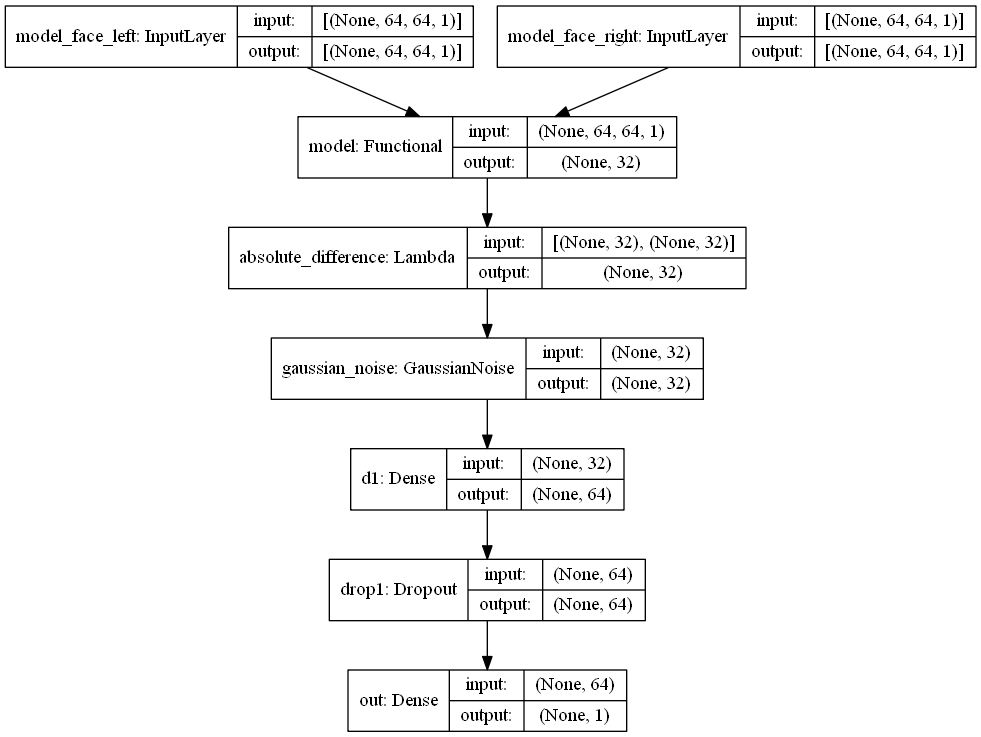

In [14]:
from IPython.display import Image
from tensorflow.keras.utils import plot_model


plot_model(facial_feature_cnn, to_file='working/model_base.png', show_shapes=True)

plot_model(model, to_file='working/model.png', show_shapes=True)


In [15]:
class CustomBatchIterator:
    def __init__(self, datagen, batch_size):
        self.datagen = datagen
        self.batch_size = batch_size
        
    def make_batch(self):
        images, labels = self.datagen.next_batch()

        output_pairs = [np.zeros((self.batch_size, *images[0].shape)) for i in range(2)]
        output_labels = np.zeros(self.batch_size)
        
        same_image_count = np.random.randint(1, self.batch_size)
        output_labels[:same_image_count] = 1

        for i in range(same_image_count):
            label = labels[i]
            random_image,_ = self.datagen.next(label) 
            output_pairs[0][i] = images[i]
            output_pairs[1][i] = random_image

        for i in range(same_image_count, self.batch_size):
            label = labels[i]
            while True:
                random_label = random.choice(self.datagen.classes)
                if random_label != label: break
            random_image,_ = self.datagen.next(random_label)
            output_pairs[0][i] = images[i]
            output_pairs[1][i] = random_image

        return output_pairs, output_labels
    
    def __iter__(self):
        return self

    def __next__(self):
        return self.make_batch()

def show_batch_pairs(image_batch_pairs, label_batch):
    fig, ax = plt.subplots(len(image_batch_pairs[0]), 2, figsize=(20,20))
    for r in range(len(image_batch_pairs[0])):
        for c in [0,1]:
            image = image_batch_pairs[c][r]
            ax[r,c].imshow(image[:,:,0], cmap='gray')
            ax[r,c].axis('off')
            ax[r,c].set_title('y=%d' % label_batch[r])
            
train_it = CustomBatchIterator(datagen_train, batch_size)
test_it  = CustomBatchIterator(datagen_test, batch_size)
#show_batch_pairs(*next(train_it))

In [17]:
history = model.fit_generator(train_it, steps_per_epoch=10, epochs=100, validation_data=test_it, validation_steps=10)

Epoch 1/100
10/10 [==============================] - 3s 312ms/step - loss: 0.6802 - accuracy: 0.5703 - val_loss: 0.7034 - val_accuracy: 0.3383
Epoch 2/100
10/10 [==============================] - 3s 309ms/step - loss: 0.6901 - accuracy: 0.5422 - val_loss: 0.6987 - val_accuracy: 0.3984
Epoch 3/100
10/10 [==============================] - 3s 309ms/step - loss: 0.6826 - accuracy: 0.5766 - val_loss: 0.6896 - val_accuracy: 0.5891
Epoch 4/100
10/10 [==============================] - 3s 309ms/step - loss: 0.7449 - accuracy: 0.3836 - val_loss: 0.6953 - val_accuracy: 0.4633
Epoch 5/100
10/10 [==============================] - 3s 311ms/step - loss: 0.7109 - accuracy: 0.4703 - val_loss: 0.6987 - val_accuracy: 0.4297
Epoch 6/100
10/10 [==============================] - 3s 311ms/step - loss: 0.6940 - accuracy: 0.5148 - val_loss: 0.6943 - val_accuracy: 0.4891
Epoch 7/100
10/10 [==============================] - 3s 328ms/step - loss: 0.6982 - accuracy: 0.5109 - val_loss: 0.6934 - val_accuracy: 0.5055

Text(0, 0.5, 'val_acc')

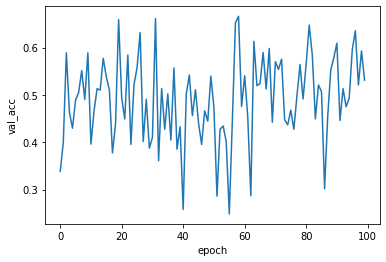

In [18]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_acc')

y=1.000 yHat=0.512
y=1.000 yHat=0.512
y=1.000 yHat=0.512
y=1.000 yHat=0.512
y=1.000 yHat=0.512
y=1.000 yHat=0.512
y=1.000 yHat=0.512
y=1.000 yHat=0.512
y=1.000 yHat=0.512
y=1.000 yHat=0.512


0.203125

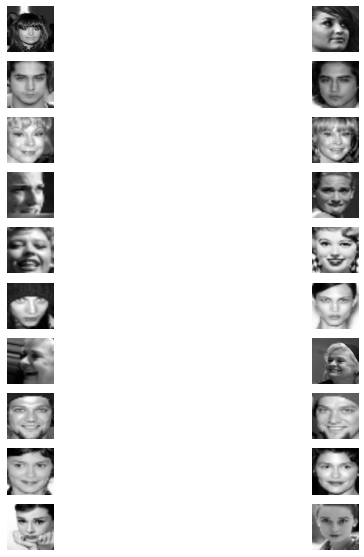

In [19]:
# Testing
test_image_pairs, test_image_labels = next(test_it)
test_image_pairs_left, test_image_pairs_right = test_image_pairs
predictions = model.predict(test_image_pairs)

accuracy = np.count_nonzero([1 if p >= 0.5 else 0 for p in predictions] == test_image_labels)/len(test_image_labels)

start = 10
items = 10
fig, ax = plt.subplots(items, 2, figsize=(10, 10))
for r in range(start, start+items):
    for c in range(0, 2):
        image = test_image_pairs[c][r]
        ax[r-start,c].imshow(image[:,:,0], cmap='gray')
        ax[r-start,c].axis('off')
    print('y=%.3f yHat=%.3f' % (test_image_labels[r], predictions[r]))

accuracy

Matched 987 to 1000: 0.512


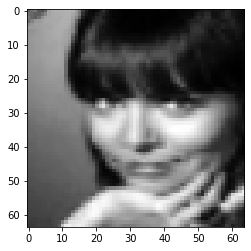

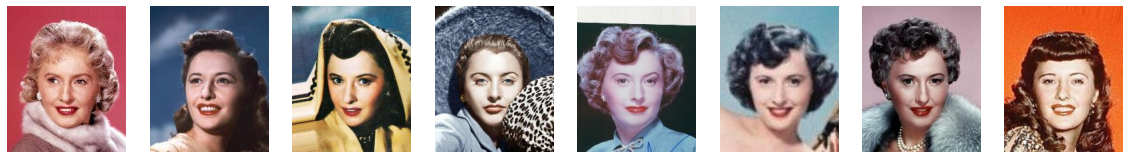

In [20]:
image, label = datagen_test.next()

def find_match(image):
    output_pairs = [np.zeros((len(datagen_test.classes), *image.shape)) for i in range(2)]
    output_pairs[0][:] = image

    for i, class_name in enumerate(datagen_test.classes):
        test_img, _ = datagen_test.next(class_name)
        output_pairs[1][i,:] = test_img

    predictions = model.predict(output_pairs)
    classes = np.array(datagen_test.classes)
    matched_class = classes[(predictions == predictions.max()).T[0]][0]
    return matched_class, predictions.max()

matched_class, confidence = find_match(image)
print('Matched %d to %d: %.3f' % (label, matched_class, confidence))

plt.imshow(image[:,:,0], cmap='gray')
show_class(str(matched_class), 'test')

In [21]:
n_trials = 100
n_correct = 0
for i in tqdm(range(n_trials)):
    image, label = datagen_test.next()
    
    matches = np.zeros(20, dtype=int)
    for i in range(0, 20):
        matches[i] = find_match(image)[0]
    
    matched_class = np.bincount(matches).argmax()
    if matched_class == label:
        n_correct += 1
print("Accuracy: %.3f" % (n_correct/n_trials))

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy: 0.000
